In [1]:
!pip install captcha

     |████████████████████████████████| 102kB 3.8MB/s 


# 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, 'D76G')

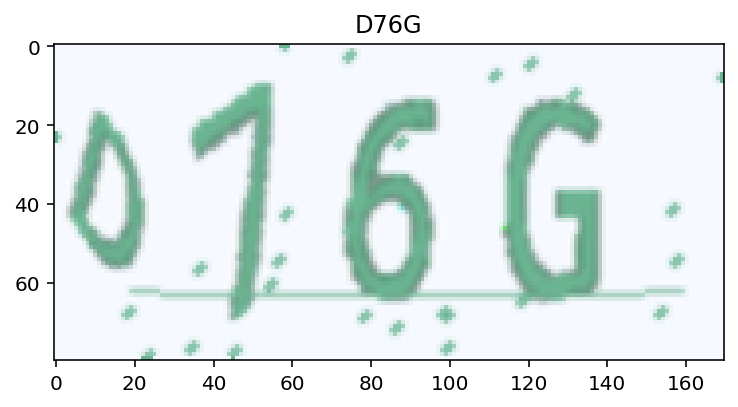

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
##驗證碼包含0-10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

##設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

##設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

##我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

# 自己搭建一個CNN模型使得output feature Map 高度被壓縮成小於4，8<寬度<20

In [0]:
from keras import backend as K
import keras

##CTC Loss需要四個資訊，分別是
## Label
## 預測
## CNN OUTPUT寬度
## 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [14]:
from keras.models import *
from keras.layers import *
from keras.backend import ctc_batch_cost

rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor

#自己設計CNN層

classifier=Sequential()

#卷積組合
classifier.add(Convolution2D(filters = 32, kernel_size = (3, 3), padding = 'same',input_shape = (height,width, 3), activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

#卷積組合
classifier.add(Convolution2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'))
classifier.add(BatchNormalization())

#卷積組合
classifier.add(Convolution2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(BatchNormalization())

#卷積組合
classifier.add(Convolution2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(BatchNormalization())

#卷積組合
classifier.add(Convolution2D(filters = 512, kernel_size = (3, 3), padding = 'same', activation='relu'))
classifier.add(MaxPooling2D(pool_size=(3,2)))
classifier.add(BatchNormalization())

x = classifier(x)
#記錄輸出CNN尺寸，loss部分需要這個資訊
##conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()

##從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(150, activation='relu')(x)

x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)


##包裝用來預測的model
base_model = Model(input=input_tensor, output=x)


##設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [15]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 3, 10, 512)   1572544     input_10[0][0]                   
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 10, 1536)     0           sequential_10[1][0]              
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 10, 150)      230550      reshape_4[0][0]                  
____________________________________________________________________________________________

In [0]:
##設計generator產生training data
## 產生包含要給loss的資訊
## X=輸入影像
## np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
## np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y,np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[33 20 27  9]]
CNN輸出寬度:  [10.]
字串長度(可浮動):  [4.]


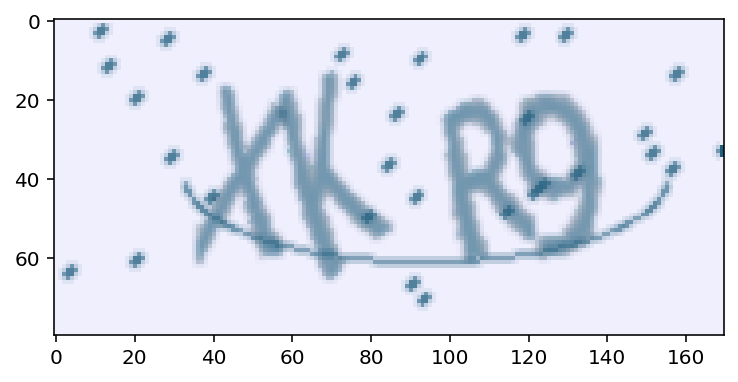

In [17]:
next_ge=gen(batch_size=1)
test_ge=next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

In [18]:
model.fit_generator(gen(32), steps_per_epoch=300, epochs=60)



Epoch 1/60
300/300 [==============================] - 53s 176ms/step - loss: 14.8457
Epoch 2/60
300/300 [==============================] - 44s 145ms/step - loss: 12.3543
Epoch 3/60
300/300 [==============================] - 44s 145ms/step - loss: 10.2970
Epoch 4/60
300/300 [==============================] - 44s 145ms/step - loss: 9.2244
Epoch 5/60
300/300 [==============================] - 44s 147ms/step - loss: 8.4538
Epoch 6/60
300/300 [==============================] - 43s 145ms/step - loss: 7.9157
Epoch 7/60
300/300 [==============================] - 43s 144ms/step - loss: 7.5133
Epoch 8/60
300/300 [==============================] - 43s 144ms/step - loss: 7.1508
Epoch 9/60
300/300 [==============================] - 43s 145ms/step - loss: 6.8654
Epoch 10/60
300/300 [==============================] - 43s 144ms/step - loss: 6.3696
Epoch 11/60
300/300 [==============================] - 43s 144ms/step - loss: 6.0366
Epoch 12/60
300/300 [==============================] - 43s 144ms/step

# 預測

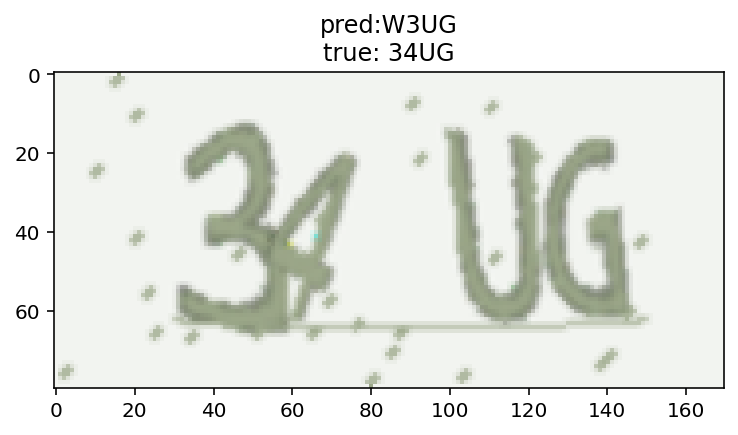

In [19]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]